In [1]:
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as BS
import urllib as url
import pandas as pd
import numpy as np

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
%matplotlib inline

In [3]:
# Initializing Request object by passing in the earthquake's url, and assigning the reults to resulttext
request = url.request.Request("https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
result = url.request.urlopen(request)
resulttext = result.read()

In [4]:
# Initialize a BeautifulSoup instance of the sring-ed version of the website's html
soup = BS(resulttext, 'html.parser')

In [5]:
# There are six different tables on the website, so I am targetting the table with specific classes. 
# This returns a list, so I assert that the list length is equal to one (so I know I am only working with one table),
# then assign the first index to my variable to reference.
earthquake_table_list = soup.find_all('table', class_=['sortable', 'wikitable', 'jquery-tablesorter'])
assert len(earthquake_table_list) == 1

earthquake_table = earthquake_table_list[0]

In [6]:
# Grab all of the 'th' elements, grab the text from each one, and assign the results to a list. 
# This will be used when creating the pandas df for column name assignment
table_header = earthquake_table.find_all('th')

columns = [th.text for th in table_header]

In [7]:
print(columns)

['Origin (UTC)', 'Present-day country and link to Wikipedia article', 'Lat', 'Long', 'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths', 'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']


In [8]:
# Find all table rows
table_rows = earthquake_table.find_all('tr')[1:]

# Create an empty list that will ultimately hold.. more lists. The nested lists will hold each individual value per 
# column, per row
df_rows = list()
for row in table_rows:
    # Grab the text from each row, and assign it to a list. Append this list to df_rows
    row_data= [data.text for data in row.find_all('td')]
    
    df_rows.append(row_data)

In [9]:
for row in df_rows[:5]:
    print(row)

['1900-05-11 17:23', 'Japan', '38.700', '141.100', '5', '7.0 MJMA', '', '', '', '', '', '']
['1900-07-12 06:25', 'Turkey', '40.300', '43.100', '', '5.9 Muk', '', '', '', '140', '', '']
['1900-10-29 09:11', 'Venezuela', '11.000', '-66.000', '0', '7.7 Mw', '', '', '', '', '', '']
['1901-02-15 00:00', 'China', '26.000', '100.100', '0', '6.5 Ms', '', '', '', '', '', '']
['1901-03-31 07:11', 'Bulgaria', '43.400', '28.700', '', '6.4 Muk', '', '', '', '4', '', '']


In [10]:
# Create a pandas df using the columns and rows we scraped.
earthquake_df = pd.DataFrame(data=df_rows, columns=columns)

# Drop 'Other Source Deaths' column, per request from README.md
earthquake_df.drop(columns=['Other Source Deaths'], inplace=True)

# Since the 'Origin (UTC)' column is a date string, I am transforming it to a datetime object and assigning it 
# to the index. I can imagine using datetime range queries later on, and converting these now seems appropriate
# and will be much easier later on. 
earthquake_df['Origin (UTC)'] = pd.to_datetime(earthquake_df['Origin (UTC)'])
earthquake_df.set_index('Origin (UTC)', inplace=True)

# Replace the remaining empty strings to np.nan values
# earthquake_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
earthquake_df.replace("", np.nan, inplace=True)

earthquake_df.columns

Index(['Present-day country and link to Wikipedia article', 'Lat', 'Long',
       'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths',
       'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths'],
      dtype='object')

In [11]:
columns_to_convert = ['PDE Total Deaths', 'PDE Shaking Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Magnitude']

In [12]:
"""There are some bad characters in this column, so this regex just grabs the int"""
for col in columns_to_convert:
    try:
        earthquake_df[col] = earthquake_df[col].str.extract('(\[\d+\]|\(.*\)|\*|\+)', expand=True)
    except ValueError:
        earthquake_df[col] = 0

In [13]:
def nan_to_int(df, columns, value=-1, inplace=True):
    """Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to -1.
    """
    for col in columns:        
        df[col].fillna(value=value, inplace=inplace)
        df[col] = pd.to_numeric(df[col], downcast='float')

In [14]:
# nan_to_int(df=earthquake_df, columns=columns_to_convert)
# nan_to_int(df=earthquake_df, columns=['Lat', 'Long'], value=0.0)

In [15]:
earthquake_df.head()

,Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths
Origin (UTC),,,,,,,,,,
1900-05-11 17:23:00,Japan,38.700,141.100,5,NaN,NaN,NaN,NaN,NaN,NaN
1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,NaN,NaN,NaN,NaN,NaN,NaN
1901-02-15 00:00:00,China,26.000,100.100,0,NaN,NaN,NaN,NaN,NaN,NaN
1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Fill all na vals with 0.0
earthquake_df['Lat'].fillna(value=0.0, inplace=True)
earthquake_df['Long'].fillna(value=0.0, inplace=True)

# Prepare a list of lat lng values to be transformed into a Point instance
lat_lng = list()
for row in earthquake_df[['Lat', 'Long']].itertuples():
    try:
        lat = float(row.Lat)
        lng = float(row.Long)
    except ValueError:
        lat = 0.0
        lng = 0.0
        
    lat_lng.append((lat, lng))

lat = [coord[0] for coord in lat_lng]
lng = [coord[1] for coord in lat_lng]

In [17]:
# Create the list for geometry column in the new GeoDataFrame
geometry = [Point(xy) for xy in zip(lng, lat)]
earthquake_df.drop(['Lat', 'Long'], axis=1)
crs = {'init': 'epsg:4326'}

# Initialize the dataframe
gdf = GeoDataFrame(earthquake_df, crs=crs, geometry=geometry)

In [18]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 1900-05-11 17:23:00 to 2011-09-23 10:41:00
Data columns (total 11 columns):
Present-day country and link to Wikipedia article    1340 non-null object
Lat                                                  1340 non-null object
Long                                                 1340 non-null object
Depth (km)                                           1250 non-null object
Magnitude                                            1 non-null object
Secondary Effects                                    373 non-null object
PDE Shaking Deaths                                   0 non-null object
PDE Total Deaths                                     0 non-null object
Utsu Total Deaths                                    0 non-null object
EM-DAT Total Deaths                                  1 non-null object
geometry                                             1340 non-null object
dtypes: object(11)
memory usage: 125.6+ KB


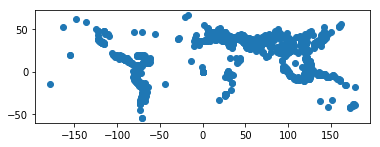

In [19]:
# Basic plot
gdf.plot()